In [1]:
import h5py 
import scipy.io
import numpy as np
import mindquantum.core.gates as Gate
import numpy as np                                          
from mindquantum.core.circuit import Circuit                
from mindquantum.core.gates import H, RX, RY, RZ,X    
from mindquantum.core.parameterresolver import PRGenerator  
from mindquantum.simulator import Simulator
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split   
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz     
from mindquantum.core.operators import QubitOperator           # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量
import mindspore as ms                                                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQLayer,MQN2Layer                                              # 导入MQLayer
# 导入HardwareEfficientAnsatz
from mindquantum.core.gates import RY           
import torch
from torchvision import datasets, transforms# 导入量子门RY
from scipy.ndimage import zoom
import random

train_num = 1000
test_num = 200

dataset = h5py.File('./Dataset/FashionMNIST_1_2_wk.mat')
train_data = np.transpose(dataset['x_train'])
train_label = np.transpose(dataset['y_train'])
test_data = np.transpose(dataset['x_test'])
test_label = np.transpose(dataset['y_test'])

train_pixels = np.array(train_data[:,:train_num].tolist())[:,:,0].transpose() # [:,:,0]取实部
test_pixels = np.array(test_data[:,:test_num].tolist())[:,:,0].transpose()
train_index = train_label[:train_num,0].astype(int) # 0-> 靴子 1->T恤
test_index = test_label[:test_num,0].astype(int)

/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR


In [2]:
from mindquantum.algorithm.library import amplitude_encoder
def amplitude_param(pixels):
    param_rd = []
    _, parameterResolver = amplitude_encoder(pixels, 8)   
    for _, param in parameterResolver.items():
        param_rd.append(param)
    param_rd = np.array(param_rd)
    return param_rd

# 将幅度转为编码线路参数，幅度shape(256,)，参数shape(255,)
train_param = np.array([amplitude_param(i) for i in train_pixels ])
test_param = np.array([amplitude_param(i) for i in test_pixels ])

In [3]:
import mindspore as ms
BATCH_SIZE = 100
train_loader = ms.dataset.NumpySlicesDataset(
    {'features': train_param, 'labels': train_index}, shuffle=True).batch(BATCH_SIZE) 
test_loader = ms.dataset.NumpySlicesDataset(
    {'features': test_param, 'labels': test_index}).batch(BATCH_SIZE)  

In [4]:
def Classifying_circuit(qubit_num, block_num, Ent_circ):
    num = qubit_num
    depth = block_num
    circ = Circuit()
    for i in range(depth):
        circ = Para_circuit(circ, num)
        if Ent_circ == 'Ent1':
            circ = Ent1_circuit(circ, num)
        elif Ent_circ == 'Ent2':
            circ = Ent2_circuit(circ, num)
        elif Ent_circ == 'Ent3':
            circ = Ent3_circuit(circ, num)
    return circ

def Ent1_circuit(circuit,qubit_num):
    for i in range(0,qubit_num-1,2):
        circuit += Gate.Z.on(i+1,i)
    for i in range(1,qubit_num-2,2):
        circuit += Gate.Z.on(i+1,i)
    return circuit

def Ent2_circuit(circuit,qubit_num):
    for i in range(0,qubit_num-1,2):
        circuit += Gate.X.on(i+1,i)
    for i in range(1,qubit_num-2,2):
        circuit += Gate.X.on(i+1,i)
    return circuit

def Ent3_circuit(circuit,qubit_num):
    circuit = Ent2_circuit(circuit,qubit_num)
    circuit = Ent2_circuit(circuit,qubit_num)
    return circuit

def Para_circuit(circuit,qubit_num):
    for i in range(qubit_num):
        circuit += Gate.RX(f'Xtheta{i}').on(i)
        circuit += Gate.RZ(f'Ztheta{i}').on(i)
        circuit += Gate.RX(f'Xtheta2{i}').on(i)
    return circuit

In [5]:
QUBIT_NUM = 8
BLOCK_NUM = 2
Ent = 'Ent3'
ansatz = Classifying_circuit(QUBIT_NUM,BLOCK_NUM,Ent).as_ansatz()

In [6]:
encoder, parameterResolver  = amplitude_encoder([0],8)
encoder = encoder.as_encoder()
encoder = encoder.no_grad()
# ansatz = HardwareEfficientAnsatz(6, single_rot_gate_seq=[RY], entangle_gate=X, depth=3).circuit     # 通过
hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [5,6]]

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(2)                                                     # 设置生成随机数的种子
circuit = encoder+ ansatz.as_ansatz()         
sim = Simulator('mqvector', 8)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         parallel_worker=5)
QuantumNet = MQLayer(grad_ops)          # 搭建量子神经网络

/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/utils/f.py:292: RuntimeWarning: invalid value encountered in divide
  return vec_in / mod(vec_in, axis=axis)


In [7]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam                                                  # 导入Adam模块用于定义优化参数
from mindspore.train import Accuracy, Model, LossMonitor                       # 导入Accuracy模块，用于评估预测准确率
import mindspore as ms
from mindspore.dataset import NumpySlicesDataset
from torch.utils.data import DataLoader# 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集

train_loader = NumpySlicesDataset({'features': train_param, 'labels': train_index}, shuffle=False).batch(20) # 通过NumpySlicesDataset创建训练样本的数据集，shuffle=False表示不打乱数据，batch(5)表示训练集每批次样本点有5个
test_loader = NumpySlicesDataset({'features': test_param, 'labels': test_index}).batch(20)       

In [8]:
loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            # 通过SoftmaxCrossEntropyWithLogits定义损失函数，sparse=True表示指定标签使用稀疏格式，reduction='mean'表示损失函数的降维方法为求平均值
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.1)                  # 通过Adam优化器优化Ansatz中的参数，需要优化的是Quantumnet中可训练的参数，学习率设为0.1

model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})             # 建立模型：将MindSpore Quantum构建的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络
class StepAcc(ms.Callback):                                                      # 定义一个关于每一步准确率的回调函数
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def on_train_step_end(self, run_context):
        
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])
        # print(f'ACC = {self.acc[-1]}')


monitor = LossMonitor(100) # 监控训练中的损失，每16步打印一次损失值

acc = StepAcc(model, test_loader)  # 使用建立的模型和测试样本计算预测的准确率

model.train(30, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)# 将上述建立好的模型训练20次

epoch: 2 step: 50, loss is 0.5813320875167847
epoch: 4 step: 50, loss is 0.5621727108955383
epoch: 6 step: 50, loss is 0.5661501884460449
epoch: 8 step: 50, loss is 0.567423403263092
epoch: 10 step: 50, loss is 0.5230658054351807
epoch: 12 step: 50, loss is 0.5199682116508484
epoch: 14 step: 50, loss is 0.5228830575942993
epoch: 16 step: 50, loss is 0.5244824290275574
epoch: 18 step: 50, loss is 0.524394154548645
epoch: 20 step: 50, loss is 0.5241962671279907
epoch: 22 step: 50, loss is 0.5241180062294006
epoch: 24 step: 50, loss is 0.524079442024231
epoch: 26 step: 50, loss is 0.5240679383277893
epoch: 28 step: 50, loss is 0.5240769982337952
epoch: 30 step: 50, loss is 0.5240951776504517


Text(0, 0.5, 'Accuracy')

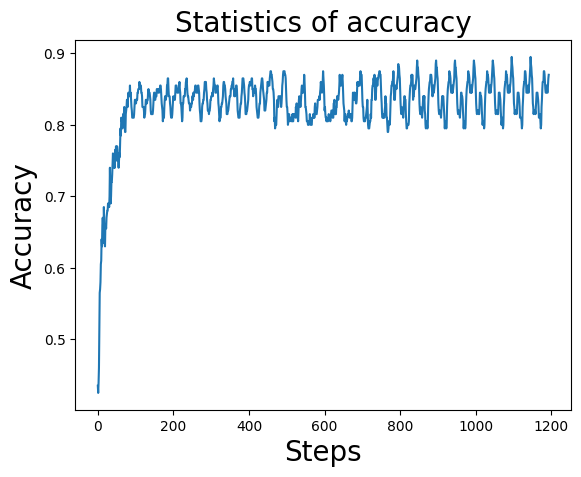

In [15]:
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)